In [4]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt

In [61]:
IMAGE_SIZE=256
BATCH_SIZE=32
CHANNELS=3
EPOCHS=50

In [9]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [10]:
class_names=dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [11]:
len(dataset)

68

[2 0 1 1 1 1 0 0 0 0 1 0 0 0 0 2 1 0 0 2 0 1 1 1 0 1 1 1 0 1 0 1]


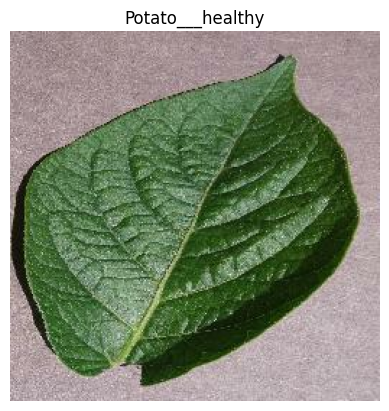

In [41]:
for image_batch,label_batch in dataset.take(1):
    plt.imshow(image_batch[0].numpy().astype('uint8'))
    plt.title(class_names[label_batch[0]])
    plt.axis("off")
    print(label_batch.numpy())

In [45]:
train_size=0.8
train_ds=dataset.take(54)
len(train_ds)

54

In [46]:
test_ds=dataset.skip(54) 
len(test_ds)

14

In [48]:
val_size=0.1
len(dataset)*val_size

6.800000000000001

In [49]:
val_ds=test_ds.take(6)
len(val_ds)

6

In [50]:
test_ds=test_ds.skip(6)
len(test_ds)

8

In [55]:
def get_dataset_partitions_tf(ds,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=10000):
    ds_size=len(ds)

    if shuffle:
        ds=ds.shuffle(shuffle_size, seed=12)

    train_size=int(train_split*ds_size)
    val_size=int(val_split*ds_size)
    train_ds=ds.take(train_size)

    val_ds=ds.skip(train_size).take(val_size)
    test_ds=ds.skip(train_size).skip(val_size)
    return train_ds,val_ds,test_ds


In [56]:
train_ds, val_ds,test_ds=get_dataset_partitions_tf(dataset)

In [57]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [64]:
resize_and_rescale=tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [65]:
data_augmentation=tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

In [67]:
input_shape=(BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNELS)
n_classes=3

model=models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32,(3,3),activation='relu',input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(n_classes,activation='softmax')


])
model.build(input_shape=input_shape)

In [68]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 sequential_3 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d_6 (Conv2D)           (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_6 (MaxPoolin  (32, 127, 127, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                 

In [70]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [72]:
history=model.fit(train_ds,epochs=5,batch_size=BATCH_SIZE,verbose=1,validation_data=val_ds)

Epoch 1/5


54/54 [==============================] - 49s 911ms/step - loss: 0.8801 - accuracy: 0.5260 - val_loss: 0.8295 - val_accuracy: 0.5885
Epoch 2/5
54/54 [==============================] - 47s 864ms/step - loss: 0.6239 - accuracy: 0.7616 - val_loss: 0.5773 - val_accuracy: 0.7604
Epoch 3/5
54/54 [==============================] - 52s 959ms/step - loss: 0.4334 - accuracy: 0.8235 - val_loss: 0.4777 - val_accuracy: 0.7656
Epoch 4/5
54/54 [==============================] - 34s 619ms/step - loss: 0.3801 - accuracy: 0.8513 - val_loss: 0.3070 - val_accuracy: 0.8698
Epoch 5/5
54/54 [==============================] - 46s 853ms/step - loss: 0.2546 - accuracy: 0.9010 - val_loss: 0.2266 - val_accuracy: 0.8854


In [73]:
scores=model.evaluate(test_ds)

8/8 [==============================] - 4s 306ms/step - loss: 0.1309 - accuracy: 0.9414


In [74]:
history

In [75]:
history.params

{'verbose': 1, 'epochs': 5, 'steps': 54}

In [76]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [77]:
history.history['accuracy']

[0.5260416865348816,
 0.7615740895271301,
 0.8234953880310059,
 0.8512731194496155,
 0.9010416865348816]

In [78]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Accuracy')

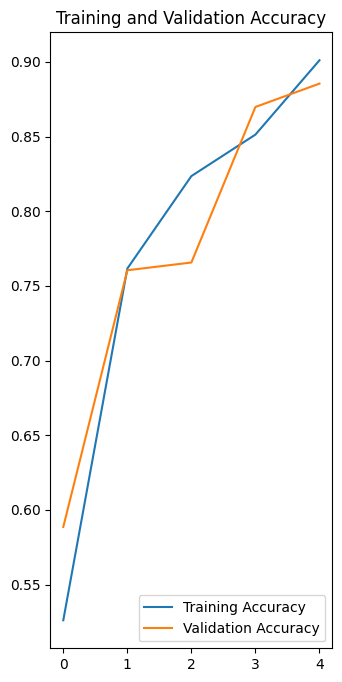

In [80]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(5),acc,label='Training Accuracy')
plt.plot(range(5),val_acc,label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

first image to predict
actual label: Potato___Late_blight
1/1 [==============================] - 0s 257ms/step
Potato___Late_blight


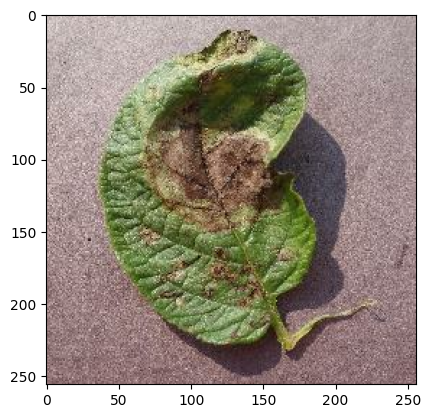

In [102]:
import numpy as np
for images_batch,labels_batch in test_ds.take(1):

    first_image=images_batch[0].numpy().astype('uint8')
    first_label=labels_batch[0].numpy()
    print('first image to predict')
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction=model.predict(images_batch)
    print(class_names[np.argmax(batch_prediction[0])])

In [103]:
def predict(model,img):
    img_array=tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array=tf.expand_dims(img_array,0)

    predictions=model.predict(img_array)
    predicted_class=class_names[np.argmax(predictions[0])]
    confidence=round(100*(np.max(predictions[0])),2)
    return predicted_class,confidence

1/1 [==============================] - 0s 29ms/step


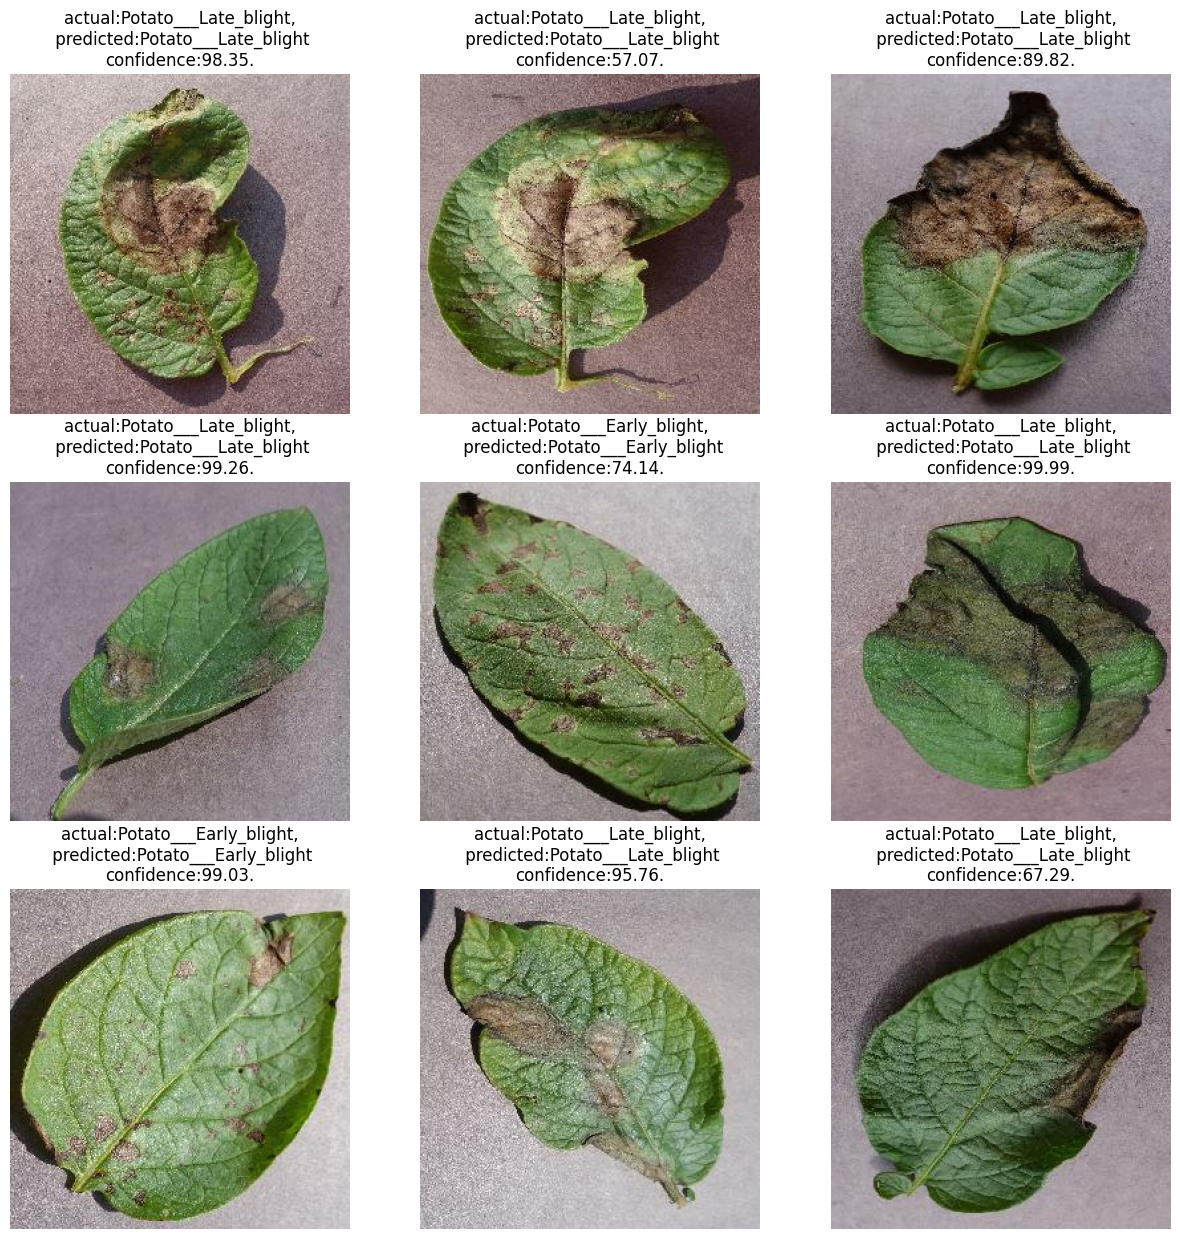

In [109]:
plt.figure(figsize=(15,15))

for images,labels in test_ds.take(1):
    for i in range(9):
        ax=plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype('uint8'))

        predicted_class,confidence=predict(model,images[i].numpy())
        actual_class=class_names[labels[i]]
        plt.title(f"actual:{actual_class},\n predicted:{predicted_class}\nconfidence:{confidence}.")
        plt.axis("off")

In [111]:
import os
model_version=max([int(i) for i in os.listdir("../models")+[0]])+1
model.save(f"../models/{model_version}")

INFO:tensorflow:Assets written to: ../models/2\assets


INFO:tensorflow:Assets written to: ../models/2\assets


In [110]:
model_version=1


INFO:tensorflow:Assets written to: ../models/1\assets


INFO:tensorflow:Assets written to: ../models/1\assets
